<a href="https://colab.research.google.com/github/manoharsingh77/Skin_Cancer_Detection/blob/main/skinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
import os

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manohar7812","key":"b0738e92ad01093f1e4427bd6334e06c"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d ./skin_cancer_data

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [01:12<00:00, 267MB/s]
100% 5.20G/5.20G [01:12<00:00, 77.4MB/s]


In [5]:
!unzip -q ham10000.zip -d /content/HAM10000

unzip:  cannot find or open ham10000.zip, ham10000.zip.zip or ham10000.zip.ZIP.


In [6]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to your dataset
base_path = '/content/skin_cancer_data'

# Load metadata
df = pd.read_csv(os.path.join(base_path, 'HAM10000_metadata.csv'))
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [7]:
# Source folders
src1 = os.path.join(base_path, 'HAM10000_images_part_1')
src2 = os.path.join(base_path, 'HAM10000_images_part_2')

# Combined folder
all_images = os.path.join(base_path, 'all_images')
os.makedirs(all_images, exist_ok=True)

# Copy both parts into one folder
for src in [src1, src2]:
    for fname in os.listdir(src):
        shutil.copy(os.path.join(src, fname), all_images)

In [8]:
# Folder to store sorted images
sorted_path = os.path.join(base_path, 'sorted')
os.makedirs(sorted_path, exist_ok=True)

for _, row in df.iterrows():
    label = row['dx']
    image_id = row['image_id'] + '.jpg'
    src = os.path.join(all_images, image_id)
    dst_dir = os.path.join(sorted_path, label)
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, image_id)
    if os.path.exists(src):
        shutil.copy(src, dst)

In [9]:
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')

for label in os.listdir(sorted_path):
    imgs = os.listdir(os.path.join(sorted_path, label))
    train_imgs, val_imgs = train_test_split(imgs, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(sorted_path, label, img), os.path.join(train_dir, label, img))
    for img in val_imgs:
        shutil.copy(os.path.join(sorted_path, label, img), os.path.join(val_dir, label, img))

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# ----------------------
# Config
# ----------------------
BASE_DIR = '/content/skin_cancer_data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR   = os.path.join(BASE_DIR, 'val')

IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
INITIAL_EPOCHS = 12
FINE_TUNE_EPOCHS = 8
FINE_TUNE_AT = -40   # unfreeze the last 40 layers of base model (tweakable)

In [11]:
# ----------------------
# Data generators (use EfficientNet preprocessing)
# ----------------------
preproc = tf.keras.applications.efficientnet.preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preproc,
    rotation_range=25,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.08,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preproc)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
class_indices = train_gen.class_indices
print("Classes:", class_indices)

Found 8010 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [12]:
# ----------------------
# Compute class weights (to help imbalance)
# ----------------------
y_train_classes = train_gen.classes  # integer labels for each file in the directory iterator
classes_unique = np.unique(y_train_classes)
cw = compute_class_weight(class_weight='balanced', classes=classes_unique, y=y_train_classes)
class_weights = {int(k): float(v) for k, v in zip(classes_unique, cw)}
print("Class weights:", class_weights)

Class weights: {0: 4.384236453201971, 1: 2.78415015641293, 2: 1.3018039980497318, 3: 12.437888198757763, 4: 1.2857142857142858, 5: 0.21332694151486098, 6: 10.126422250316056}


In [13]:
# ----------------------
# Build model (base frozen)
# ----------------------
base_model = EfficientNetB0(weights='imagenet', include_top=False,
                           input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
# ----------------------
# Callbacks
# ----------------------
checkpoint_path = 'efficientnetb0_ham10000_best.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

In [15]:
# ----------------------
# Train classifier head
# ----------------------
history1 = model.fit(
    train_gen,
    epochs=INITIAL_EPOCHS,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.3453 - loss: 1.8393
Epoch 1: val_accuracy improved from -inf to 0.35810, saving model to efficientnetb0_ham10000_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 215s 745ms/step - accuracy: 0.3455 - loss: 1.8389 - val_accuracy: 0.3581 - val_loss: 1.5604 - learning_rate: 0.0010
Epoch 2/12
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.4508 - loss: 1.4913
Epoch 2: val_accuracy improved from 0.35810 to 0.58005, saving model to efficientnetb0_ham10000_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 555ms/step - accuracy: 0.4510 - loss: 1.4910 - val_accuracy: 0.5800 - val_loss: 1.2065 - learning_rate: 0.0010
Epoch 3/12
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.5181 - loss: 1.3023
Epoch 3: val_accuracy did not improve from 0.58005
251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 554ms/step - accuracy: 0.5181 - loss: 1.3023 - val_accuracy: 0.5671 - val_loss: 1.2192 - learning_rate: 0.0010
Epoch 4/12
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5175 - loss: 1.2318
Epoch 4: val_accuracy improved from 0.58005 to 0.62743, saving model to efficientnetb0_ham10000_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 137s 548ms/step - accuracy: 0.5176 - loss: 1.2317 - val_accuracy: 0.6274 - val_loss: 1.0922 - learning_rate: 0.0010
Epoch 5/12
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.5339 - loss: 1.2089
Epoch 5: val_accuracy did not improve from 0.62743
251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 550ms/step - accuracy: 0.5339 - loss: 1.2089 - val_accuracy: 0.5900 - val_loss: 1.1378 - learning_rate: 0.0010
Epoch 6/12
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.5270 - loss: 1.2055
Epoch 6: val_accuracy did not improve from 0.62743
251/251 ━━━━━━━━━━━━━━━━━━━━ 138s 548ms/step - accuracy: 0.5270 - loss: 1.2054 - val_accuracy: 0.6269 - val_loss: 1.0483 - learning_rate: 0.0010
Epoch 7/12
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.5544 - loss: 1.1249
Epoch 7: val_accuracy improved from 0.62743 to 0.65037, saving model to efficientnetb0_ham10000_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 138s 550ms/step - accuracy: 0.5544 - loss: 1.1250 - val_accuracy: 0.6504 - val_loss: 1.0192 - learning_rate: 0.0010
Epoch 8/12
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.5822 - loss: 1.0959
Epoch 8: val_accuracy did not improve from 0.65037
251/251 ━━━━━━━━━━━━━━━━━━━━ 138s 548ms/step - accuracy: 0.5821 - loss: 1.0960 - val_accuracy: 0.5541 - val_loss: 1.1792 - learning_rate: 0.0010
Epoch 9/12
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.5534 - loss: 1.1008
Epoch 9: val_accuracy did not improve from 0.65037
251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 555ms/step - accuracy: 0.5534 - loss: 1.1009 - val_accuracy: 0.6160 - val_loss: 1.0384 - learning_rate: 0.0010
Epoch 10/12
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5586 - loss: 1.1052
Epoch 10: val_accuracy did not improve from 0.65037

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
251/251 ━━━━━━━━━━━━━━━━━━━━ 137s 545ms/step - accuracy: 0.5586 - lo

In [21]:
# ----------------------
# Fine-tuning: unfreeze last few layers of base model
# ----------------------
# Decide how many layers to unfreeze
FINE_TUNE_AT=-10
if FINE_TUNE_AT < 0:
    # negative index means relative to end; convert to positive cut index
    cutoff = len(base_model.layers) + FINE_TUNE_AT
else:
    cutoff = FINE_TUNE_AT

for i, layer in enumerate(base_model.layers):
    layer.trainable = True if i >= cutoff else False

# recompile with lower LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Unfroze layers from index {cutoff} -> {len(base_model.layers)-1}")
model.summary()

Unfroze layers from index 228 -> 237


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 902,199 (3.44 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

In [17]:
history2 = model.fit(
    train_gen,
    epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history1.epoch[-1] + 1 if hasattr(history1, 'epoch') else INITIAL_EPOCHS,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 13/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.2716 - loss: 1.4537
Epoch 13: val_accuracy did not improve from 0.65037
251/251 ━━━━━━━━━━━━━━━━━━━━ 217s 736ms/step - accuracy: 0.2716 - loss: 1.4535 - val_accuracy: 0.3796 - val_loss: 1.6178 - learning_rate: 1.0000e-05
Epoch 14/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.3245 - loss: 1.4141
Epoch 14: val_accuracy did not improve from 0.65037
251/251 ━━━━━━━━━━━━━━━━━━━━ 148s 591ms/step - accuracy: 0.3245 - loss: 1.4139 - val_accuracy: 0.3830 - val_loss: 1.5602 - learning_rate: 1.0000e-05
Epoch 15/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.3711 - loss: 1.3659
Epoch 15: val_accuracy did not improve from 0.65037
251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 555ms/step - accuracy: 0.3711 - loss: 1.3656 - val_accuracy: 0.4254 - val_loss: 1.4466 - learning_rate: 1.0000e-05
Epoch 16/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.3961 - loss: 1.2278
Epoch 16: val_accuracy did not improve fr

63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 256ms/step - accuracy: 0.5767 - loss: 1.1543
Validation Loss: 1.1315
Validation Accuracy: 0.5661
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step


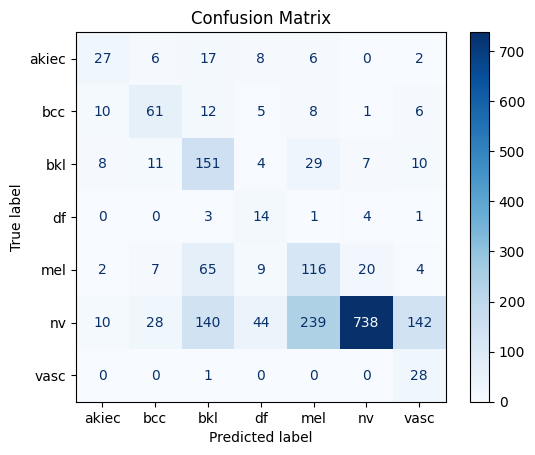

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ----------------------
# Evaluate model
# ----------------------


# Using the validation set for demonstration if no test set
loss, accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# ----------------------
# Confusion Matrix
# ----------------------
# Get predictions on the validation set
predictions = model.predict(val_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = val_gen.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

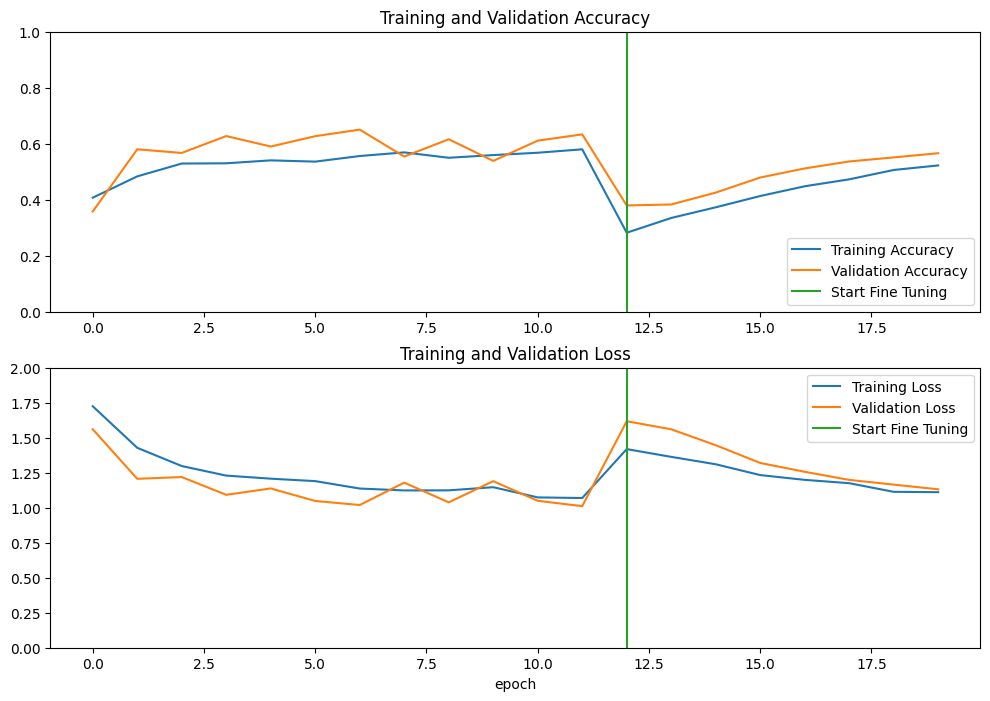

In [20]:
# ----------------------
# Plot training history
# ----------------------
def plot_history(history, history_fine, initial_epochs):
    """
    Plots training and validation accuracy and loss from training history.

    Args:
        history: History object from the initial training phase.
        history_fine: History object from the fine-tuning phase.
        initial_epochs: Number of epochs in the initial training phase.
    """
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0, 1])
    plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 2.0])
    plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Plot the history
plot_history(history1, history2, INITIAL_EPOCHS)